<table><tr>
<td> <img src="https://upload.wikimedia.org/wikipedia/fr/thumb/e/e5/Logo_%C3%A9cole_des_ponts_paristech.svg/676px-Logo_%C3%A9cole_des_ponts_paristech.svg.png" width="200"  height="200" hspace="200"/> </td>
<td> <img src="https://pbs.twimg.com/profile_images/1156541928193896448/5ihYIbCQ_200x200.png" width="200" height="200" /> </td>
</tr></table>

<br/>

<h1><center>Session 6 - Unsupervised modeling</center></h1>



<font size="3">This session is divided into **3** parts:
- **Loading data**
- **Clustering**
- **Topic modeling**

In each of these parts, some **guidelines** and **hints** are given for each task. 
Do not hesitate to check the links to documentation to understand the functions you use. 
    
The goal of this session is to **implement different unsupervised models** to **create clusters** among movies and to see **which topics emerge** from movies description.
</font>

# 0 - Useful libraries

In [58]:
import pandas as pd
import numpy as np
import random as rd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import hdbscan
from top2vec import Top2Vec
from matplotlib import pyplot as plt
from scipy.special import softmax
import wordcloud
import gensim
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis.gensim
import pyLDAvis
# Pre-requisites for top2vec: keras_applications, keras_preprocessing

# [OPTIONAL]
from nlpretext import Preprocessor
from nlpretext.basic.preprocess import *

# 1. Loading data

In [200]:
# Load dataset for unsupervised modeling
data = pd.read_csv('dataset_unsupervised.csv')

# Load tagline data
with open('movies_tagline.json', 'r') as f:
    tagline = json.load(f)
df_tagline = pd.DataFrame.from_dict(tagline, orient='index', columns=['tagline']).reset_index().rename({'index': 'id'}, axis=1)
df_tagline['id'] = df_tagline['id'].astype(int)

# Load overview data
with open('movies_overview.json', 'r') as f:
    overview = json.load(f)
df_overview = pd.DataFrame.from_dict(overview, orient='index', columns=['overview']).reset_index().rename({'index': 'id'}, axis=1)
df_overview['id'] = df_overview['id'].astype(int)

# Merge datasets
data = data.merge(df_tagline, on='id', how='left').merge(df_overview, on='id', how='left')

# Create dictionary to associate a movie ID to its title (will be used for exploration later)
dict_title = data[['id', 'title']].set_index('id').to_dict()['title']

# Drop variables useless for the modeling part (clustering and topic modeling)
data = data.drop(['release_date', 'title', 'index'], axis=1)

In [201]:
data.head()

,year,sales,is_part_of_collection,budget,runtime,original_lang_en,original_lang_es,original_lang_fr,original_lang_it,original_lang_ja,...,mean_3_popularity,mean_5_popularity,actor_1_sales,actor_2_sales,actor_3_sales,mean_sales_actor,max_sales_actor,id,tagline,overview
0,2000,139087,0,25000000.0,120.0,0,0,1,0,0,...,0.489158,0.373572,0.0,0.0,0.0,0.0,0.0,2475,,Comme les Mousquetaires dont elles possèdent l...
1,2000,66228,0,22000000.0,142.0,1,0,0,0,0,...,1.404085,1.229533,0.0,0.0,0.0,0.0,0.0,2870,,"New York, été 1977. Alors que la ville connait..."
2,2000,1463152,0,25000000.0,77.0,0,1,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,2706,,
3,2000,32954,0,25000000.0,116.0,1,0,0,0,0,...,0.465217,0.346425,0.0,0.0,0.0,0.0,0.0,11980,,"Félicia, dix-sept ans, traverse la mer d'Irlan..."
4,2000,223564,1,40000000.0,99.0,1,0,0,0,0,...,2.802817,2.044138,0.0,0.0,0.0,0.0,0.0,2480,Il reprend du service.,Arthur Bishop pensait qu'il avait mis son pass...


# 2. Clustering

In [204]:
# For movie clustering, textual variables are not usefull, let's drop them
data_clustering = data.drop(['overview', 'tagline'], axis=1)

In [205]:
# Split the dataset into a train part and a test part (with a ratio 80/20 for example)
# Hint: take a look at the train_test_split() function from sklearn 
# (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
X_train, X_test = train_test_split(data_clustering, test_size = 0.2)

## 2.1. K-means

In [247]:
X_test_kmeans = X_test.copy()

In [248]:
# Choose a number k of clusters 
k = 10

In [249]:
# Initialize a K-means model
km = KMeans(n_clusters = k, random_state = 0)

In [250]:
# Fit the K-means model to your data
km = km.fit(X_train)

In [251]:
# Predict on your test set
predictions = km.predict(X_test_kmeans)

In [252]:
# Explore your results
# Hint: merge your predictions with your initial dataset X_test_kmeans and use the dict_title object to retrieve which title is associated to
# each movie ID. From there you will be able to know which movies are in each cluster
X_test_kmeans['prediction'] = predictions
X_test_kmeans['title'] = X_test_kmeans['id'].map(dict_title)

In [253]:
# Print the first 10 movies associated to a each cluster
for nb in set(X_test_kmeans['prediction']):
    print('Cluster: ', nb)
    print('Number of movies in cluster: ', len(X_test_kmeans.loc[X_test_kmeans['prediction'] == nb]['title']))
    print('Titles: ', X_test_kmeans.loc[X_test_kmeans['prediction'] == nb]['title'][:10])
    print('----- ')

Cluster:  0
Number of movies in cluster:  880
Titles:  472                       Tanguy
6650       Le Bonheur des uns...
4641               Les Héritiers
1507          Camping à la ferme
133                        Aïe !
4473    The Two Faces of January
3946                      Renoir
1935     Les Fragments d'Antonin
3757           Une seconde femme
2704            Celle que j'aime
Name: title, dtype: object
----- 
Cluster:  1
Number of movies in cluster:  21
Titles:  5257                           Suicide Squad
4496    Transformers : l'âge de l'extinction
3454                                  Cars 2
2140                            Transformers
3923                     Les Mondes de Ralph
5886                        Ready Player One
5539            Les Gardiens de la Galaxie 2
1796              X-Men l'affrontement final
5226                           Tarzan (2016)
5631                                  Cars 3
Name: title, dtype: object
----- 
Cluster:  2
Number of movies in cluster:  3

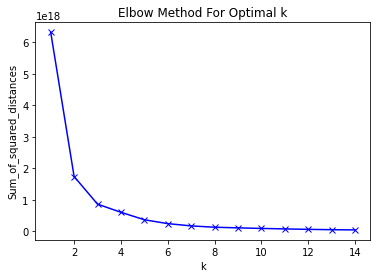

In [254]:
# To go further:
# Try the elbow method to find the optimal number k of clusters. Train a new K-means model with this number, make predictions and explore the
# results
# Hint: use the function plot_elbow() to determine the optimal k
X_test_kmeans = X_test.copy()

def plot_elbow(X_train, K):
    Sum_of_squared_distances = []
    for k in range(1, K):
        km = KMeans(n_clusters = k, random_state = 0)
        km = km.fit(X_train)
        Sum_of_squared_distances.append(km.inertia_)
    plt.plot(range(1, K), Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    
plot_elbow(X_train, 15)

In [255]:
# Define optimal k and re-train a K-means model
optimal_k = 4
km = KMeans(n_clusters=optimal_k, random_state=0).fit(X_train)

# Make predictions on test set and add corresponding title
X_test_kmeans['prediction'] = km.predict(X_test_kmeans)
X_test_kmeans['title'] = X_test_kmeans['id'].map(dict_title)

In [256]:
# Print the first 10 movies associated to a each cluster
for nb in set(X_test_kmeans['prediction']):
    print('Cluster: ', nb)
    print('Number of movies in cluster: ', len(X_test_kmeans.loc[X_test_kmeans['prediction'] == nb]['title']))
    print('Titles: ', X_test_kmeans.loc[X_test_kmeans['prediction'] == nb]['title'][:10])
    print('----- ')

Cluster:  0
Number of movies in cluster:  233
Titles:  5174                    Mr. Holmes
5181                      Ma Loute
4599                          Chef
213                Aniki mon frère
4544                  Gemma Bovery
4853                Magic Mike XXL
5331           Ma vie de courgette
968               Good Bye, Lenin!
1153         La Mauvaise éducation
2490    Inju, la bête dans l'ombre
Name: title, dtype: object
----- 
Cluster:  1
Number of movies in cluster:  43
Titles:  5257                                     Suicide Squad
4496              Transformers : l'âge de l'extinction
3454                                            Cars 2
2209                                       Rush Hour 3
3395    Pirates des Caraïbes : la Fontaine de Jouvence
1023                                Matrix Revolutions
6222                               Alita: Battle Angel
2147                                       Ratatouille
3068            Prince of Persia : les sables du temps
2140        

## 2.2. To go further on clustering: HDBSCAN
HDBSCAN is another clustering model. 
Its advantage is that it determines automatically the number of clusters, it does not need to be defined beforehand.

In [257]:
X_test_hdbscan = X_test.copy()

In [258]:
# Initialize a HDBSCAN model
# Hint: take a look at the hdbscan package (https://hdbscan.readthedocs.io/en/latest/)
clusterer = hdbscan.HDBSCAN(prediction_data = True)
clusterer.fit(X_train)

HDBSCAN(prediction_data=True)

In [259]:
# Find the number of clusters that HDBSCAN has determined
train_labels = clusterer.labels_
print('Number of clusters:', len(set(X_train_hdbscan['hdbscan_labels'])))

Number of clusters: 126


In [260]:
# Make predictions on the test set
# Hint: check the methods associated to an HDBSCAN model (https://hdbscan.readthedocs.io/en/latest/api.html#hdbscan)
predictions, scores = hdbscan.approximate_predict(clusterer, X_test_hdbscan)

In [261]:
# Append predictions and scores to the test set
X_test_hdbscan['hdbscan_labels'] = predictions
X_test_hdbscan['hdbscan_score'] = scores

# Add the title associated to each movie
X_test_hdbscan['title'] = X_test_hdbscan['id'].map(dict_title)

In [262]:
# Explore results
for nb in set(X_test_hdbscan['hdbscan_labels']):
    print('Cluster: ', nb)
    print('Number of movies in cluster: ', len(X_test_hdbscan.loc[X_test_hdbscan['hdbscan_labels'] == nb]['title']))
    print('Titles: ', X_test_hdbscan.loc[X_test_hdbscan['hdbscan_labels'] == nb]['title'])
    print('-------')

Cluster:  0
Number of movies in cluster:  2
Titles:  2772    Harry Potter et le Prince de sang-mêlé
5474                                      Lion
Name: title, dtype: object
-------
Cluster:  1
Number of movies in cluster:  1
Titles:  2140    Transformers
Name: title, dtype: object
-------
Cluster:  2
Number of movies in cluster:  6
Titles:  3454                                              Cars 2
5539                        Les Gardiens de la Galaxie 2
1845    Pirates des Caraïbes, le secret du coffre maudit
3462                                       Green Lantern
2542                                   Quantum of Solace
5533                                    Fast & Furious 8
Name: title, dtype: object
-------
Cluster:  6
Number of movies in cluster:  2
Titles:  6222      Alita: Battle Angel
406     La Planète des singes
Name: title, dtype: object
-------
Cluster:  7
Number of movies in cluster:  12
Titles:  5257                                Suicide Squad
3923                       

Number of movies in cluster:  6
Titles:  2038        Ecrire pour exister
2249    La Nuit nous appartient
6018          Contrôle parental
2181       Joyeuses funérailles
3498    Et maintenant on va où?
2136              Dead or Alive
Name: title, dtype: object
-------
Cluster:  41
Number of movies in cluster:  4
Titles:  45      La Fin d'une liaison
418       Attraction animale
2694                   Chéri
1314               Bad Santa
Name: title, dtype: object
-------
Cluster:  42
Number of movies in cluster:  5
Titles:  582               Sam, je suis Sam
2845                 The Informant
3611    La Colline aux Coquelicots
1                    Summer of Sam
984                     Underworld
Name: title, dtype: object
-------
Cluster:  43
Number of movies in cluster:  1
Titles:  546    John Q
Name: title, dtype: object
-------
Cluster:  44
Number of movies in cluster:  14
Titles:  2365                     Deux soeurs pour un roi
837                        La Famille Delajungle
3116   

Name: title, dtype: object
-------
Cluster:  73
Number of movies in cluster:  3
Titles:  1558                          Ma vie en l'air
2321    Le Merveilleux magasin de Mr Magorium
2971                                       12
Name: title, dtype: object
-------
Cluster:  75
Number of movies in cluster:  1
Titles:  5617    Sales Gosses
Name: title, dtype: object
-------
Cluster:  77
Number of movies in cluster:  1
Titles:  1067    Le Dernier samouraï
Name: title, dtype: object
-------
Cluster:  79
Number of movies in cluster:  6
Titles:  2446                        Balles de feu
151                            Jesus' Son
453     Grégoire Moulin contre l'humanité
3811                          Les Saphirs
80                   Il suffit d'une nuit
325                    L'Origine du monde
Name: title, dtype: object
-------
Cluster:  80
Number of movies in cluster:  1
Titles:  6008    Maya l'abeille 2 - Les jeux du miel
Name: title, dtype: object
-------
Cluster:  83
Number of movies in clus

# 3. Topic modeling

In [193]:
custom_stopwords = ['vie', 'ans', 'jeune', 'film', 'femme', 'homme', 'famille', 'pere', 'fille', 'mere', 'monde',
                    'jour', 'ete']

def preprocess(df_text, custom_stopwords=custom_stopwords):
    df_text = df_text.loc[df_text['text'] != ' ']
    df_text['text_prepro'] = df_text['text'].map(fix_bad_unicode)
    df_text['text_prepro'] = df_text['text_prepro'].map(lower_text)
    df_text['text_prepro'] = df_text['text_prepro'].map(remove_eol_characters)
    df_text['text_prepro'] = df_text['text_prepro'].map(remove_accents)
    df_text['text_prepro'] = df_text['text_prepro'].map(remove_punct)
    df_text['text_prepro'] = df_text['text_prepro'].map(lambda x: remove_stopwords(
        x, lang='fr', custom_stopwords=custom_stopwords))
    df_text['text_prepro'] = df_text['text_prepro'].map(normalize_whitespace)
    df_text['tokens'] = df_text['text_prepro'].map(lambda x: x.split())
    return df_text


def make_word_cloud(text_df: pd.DataFrame):
    """
    Function that computes word cloud from tokens

    Parameters
    ----------
    text_df: pd.DataFrame
        dataframe with text column
    cmp: matplotlib.colors.LinearSegmentedColormap
        colormap for the wordcloud
    """
    text = ' '.join([' '.join(el) for el in text_df['tokens']])
    if isinstance(text, str):
        wordcloud_ = wordcloud.WordCloud(background_color='white', width=700, height=500).generate(text)
        #wordcloud_.recolor(colormap=cmp)
    else:
        raise TypeError('text_df contains non str values')
    plt.imshow(wordcloud_)
    plt.axis("off")
    plt.show()

In [268]:
# Create a 'text' column that is a combination of the tagline and the overview
# Example:
# - tagline = 'Il reprend du service.'
# - overview = 'Arthur Bishop pensait qu'il avait mis son passé de tueur à gages derrière lui. ... etc'
# -> text = 'Il reprend du service. Arthur Bishop pensait qu'il avait mis son passé de tueur à gages derrière lui. ... etc'
data['text'] = data['tagline'] + ' ' + data['overview']

In [269]:
# Preprocess the 'text' column:
# - transform the text to lowercase
# - remove end of line characters
# - remove accents
# - remove punctuation
# - remove stopwords
# - split the preprocessed text into words (i.e. tokens) and store it into a new column named 'tokens'
data = preprocess(data)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A val

## 3.1 LDA

In [272]:
# Create a list of all tokens associated to each movie and store it into the variable data_words
data_words = data['tokens'].tolist()
print(data_words[:1][0][:10])

['mousquetaires', 'possedent', 'cran', 'ame', 'festive', 'sens', 'amitie', 'battantes', 'vivent', 'paris']


In [ ]:
# Create a Dictionary based on the all the words per movie
# Hint: explore the gensim library (specifically the 'corpora' section...)
id2word = corpora.Dictionary(data_words)

In [ ]:
# Create a Corpus for each text associated to each movie
text = data_words
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:30])

In [ ]:
# Define a number of topics
num_topics = 7

In [ ]:
# Train a LDA model
# Hint: explore the gensim library (specifically the 'models' section...)
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

In [146]:
# Print the keywords in the n topics
# Hint: maybe the gensim LDA model has a built-in function to do so...
pprint(lda_model.print_topics())

[(0,
  '0.004*"histoire" + 0.003*"fils" + 0.002*"part" + 0.002*"guerre" + '
  '0.002*"enfants" + 0.002*"amour" + 0.002*"roi" + 0.002*"voyage" + '
  '0.002*"face" + 0.002*"temps"'),
 (1,
  '0.004*"amour" + 0.004*"histoire" + 0.004*"grand" + 0.004*"parents" + '
  '0.003*"nouvelle" + 0.003*"annees" + 0.003*"amis" + 0.003*"passe" + '
  '0.002*"ami" + 0.002*"maison"'),
 (2,
  '0.004*"petit" + 0.003*"grand" + 0.003*"decide" + 0.003*"histoire" + '
  '0.003*"passe" + 0.003*"petite" + 0.003*"fils" + 0.003*"temps" + '
  '0.003*"decouvre" + 0.003*"vient"'),
 (3,
  '0.005*"enfants" + 0.003*"rencontre" + 0.003*"ville" + 0.002*"maison" + '
  '0.002*"amis" + 0.002*"jamais" + 0.002*"aventure" + 0.002*"petit" + '
  '0.002*"parents" + 0.002*"mari"'),
 (4,
  '0.005*"annees" + 0.004*"histoire" + 0.003*"retrouve" + 0.003*"rencontre" + '
  '0.003*"parents" + 0.003*"petit" + 0.003*"temps" + 0.003*"fils" + '
  '0.003*"decide" + 0.003*"grand"'),
 (5,
  '0.005*"ville" + 0.003*"decide" + 0.003*"rencontre" + 0.00

In [147]:
# Visualize the topics
# Hint: use pyLDAvis
pyLDAvis.enable_notebook()
LDAvis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.016789 -0.029930       1        1  17.350918
5     -0.037514  0.036332       2        1  15.111910
3     -0.009392 -0.036387       3        1  14.895454
2     -0.012964  0.055400       4        1  14.153530
1     -0.011368 -0.055616       5        1  13.973156
0     -0.009102  0.021922       6        1  12.755716
6      0.097130  0.008279       7        1  11.759320, topic_info=          Term        Freq       Total Category  logprob  loglift
163   histoire  917.000000  917.000000  Default  30.0000  30.0000
434    enfants  473.000000  473.000000  Default  29.0000  29.0000
697     voyage  296.000000  296.000000  Default  28.0000  28.0000
54       ville  536.000000  536.000000  Default  27.0000  27.0000
248    parents  483.000000  483.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
502       fils   53.649075  531.481445   Topic7  -6.3015  -0.1527
340   nouvelle   49.702213  430.054962   Topic7  -6.3779  -0.0173
264        vit   45.861965  396.794586   Topic7  -6.4583  -0.0173
1179  aventure   43.556427  348.855865   Topic7  -6.5099   0.0599
503     jamais   44.668583  433.710754   Topic7  -6.4847  -0.1326

[649 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
26164      4  0.885438        1770
32044      2  0.909962        1849
9363       1  0.624086          60
9363       2  0.093613          60
9363       3  0.031204          60
...      ...       ...         ...
16112      4  0.044038     zombies
16112      5  0.044038     zombies
16112      6  0.044038     zombies
16112      7  0.660576     zombies
31933      6  0.855342  zoologique

[1777 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 4, 3, 2, 1, 7])

In [ ]:
# What are your conclusions regarding the topics? (coherence, stability, ...)

## 3.2 To go further on topic modeling: Top2Vec

In [273]:
# Create a new dataset for top2vec model, from the 'data' dataframe, do not take movies with empty text 
# into account
data_top2vec = data.loc[data['text'] != '']

# Make a list from the 'text' column that will contain all texts associated to all movies
all_texts = data_top2vec["text"].tolist()

In [ ]:
# Train a top2vec model
model = Top2Vec(documents=all_texts, speed="learn")

In [149]:
# Explore the results:
# - number of topics found
# - topics sizes

n_topics_found = model.get_num_topics()
topic_sizes, topic_nums = model.get_topic_sizes()
print('Number of topics found:', n_topics_found)
print('Topic sizes:')
for n in range(n_topics_found):
    print('Topic ', n, ' - Size: ', topic_sizes[n])
    print(' ----- ')

Number of topics found: 4
Topic sizes:
Topic  0  - Size:  5596
 ----- 
Topic  1  - Size:  322
 ----- 
Topic  2  - Size:  245
 ----- 
Topic  3  - Size:  232
 ----- 


In [9]:
# Explore the results part 2: 
# - check the texts with the best scores in each cluster
# - make wordclouds for each cluster


model_bis = Top2Vec.load('top2vec_imdb.pickle')
n_topics_found = model_bis.get_num_topics()
topic_sizes, topic_nums = model_bis.get_topic_sizes()


nb = 11
documents, document_scores, document_ids = model_bis.search_documents_by_topic(topic_num = nb, num_docs = 7)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print(doc)
    print("-----------")

Document: 2189, Score: 0.9106067419052124
 Un fantôme au visage masqué hante les coulisses de l'Opéra de Paris. Amoureux d'une jeune cantatrice, il la séquestre dans l'espoir de susciter son amour.
-----------
Document: 5042, Score: 0.8995142579078674
 Deux amis mariés vont de nouveau rencontrer l'amour... L'un d'eux va voir sa vie bouleversée par l'accident grave d'un de ses fils.
-----------
Document: 2807, Score: 0.8875844478607178
 Lorsque Winfried, 65 ans, rend une visite surprise à sa fille Ines, 37 ans, en Roumanie, il pense que cette dernière a perdu le sens de l'humour et décide de l'aider à le retrouver, en multipliant les farces.
-----------
Document: 780, Score: 0.8870965242385864
 Julie anime une fête dans une école de cinéma quand elle rencontre un homme mystérieux nommé Anthony. Quelques jours plus tard, Anthony invite Julie dans un grand hôtel et lui demande de rester quelques jours avec elle. Ainsi commence la première histoire d’amour sérieuse de Julie. Ignorant ses a

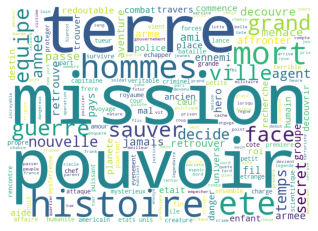

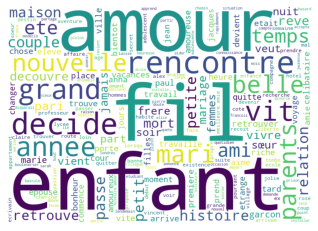

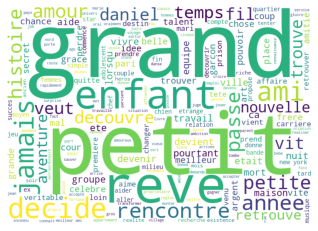

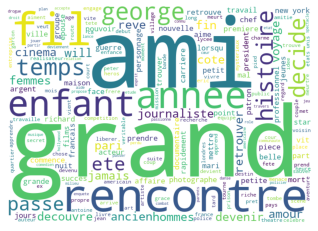

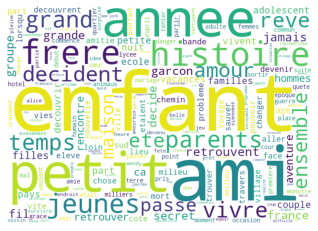

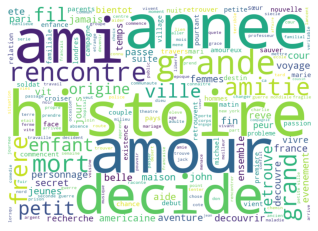

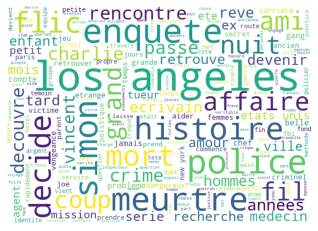

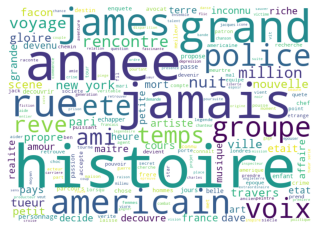

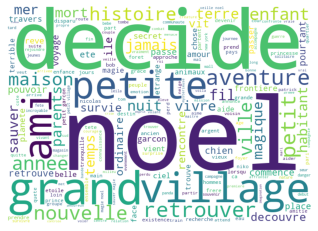

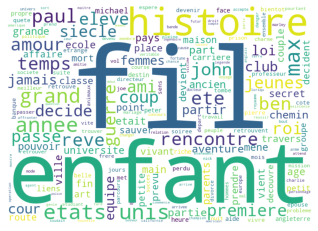

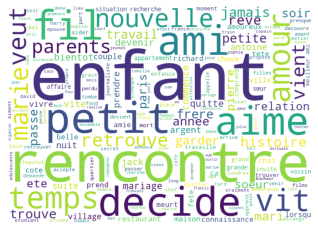

In [29]:
for nb in range(11):
    documents, document_scores, document_ids = model_bis.search_documents_by_topic(topic_num=nb, num_docs=topic_sizes[nb])
    df_text = preprocess(documents)
    make_word_cloud(df_text)

In [ ]:
# What would be your interpretation for each cluster ?

# Topic 0: action
# Topic 1: comédie romantique
# Topic 2: drame
# Topic 3: Court-metrage
# Topic 4: histoire de jeunes, duos
# Topic 5: histoire de famille
# Topic 6: flic, los angeles
# Topic 7: art, culture
# Topic 8: noël
# Topic 9: aventure
# Topic 10: amour

In [155]:
# Save your model for later if you want to explore it in more details
# model.save('top2vec_imdb_bis.pickle')